In [11]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

plt.rcParams["figure.figsize"] = (20,15)

# Lab 3

Problem 1: Given a normal distribution of temperature readings with mean 12 and standard deviation 0.4, there are some 'bad' entries that are due either to large fluctuations in temperature or misread data. In either case, we want to throw out data that falls under this category.

A: 1/2) Let's start by thoroughly inspecting the distribution while asking ourselves, "What is the optimal threshold value to throw out data outside that threshold to maximize the number of valid data and minimize the number of invalid?":

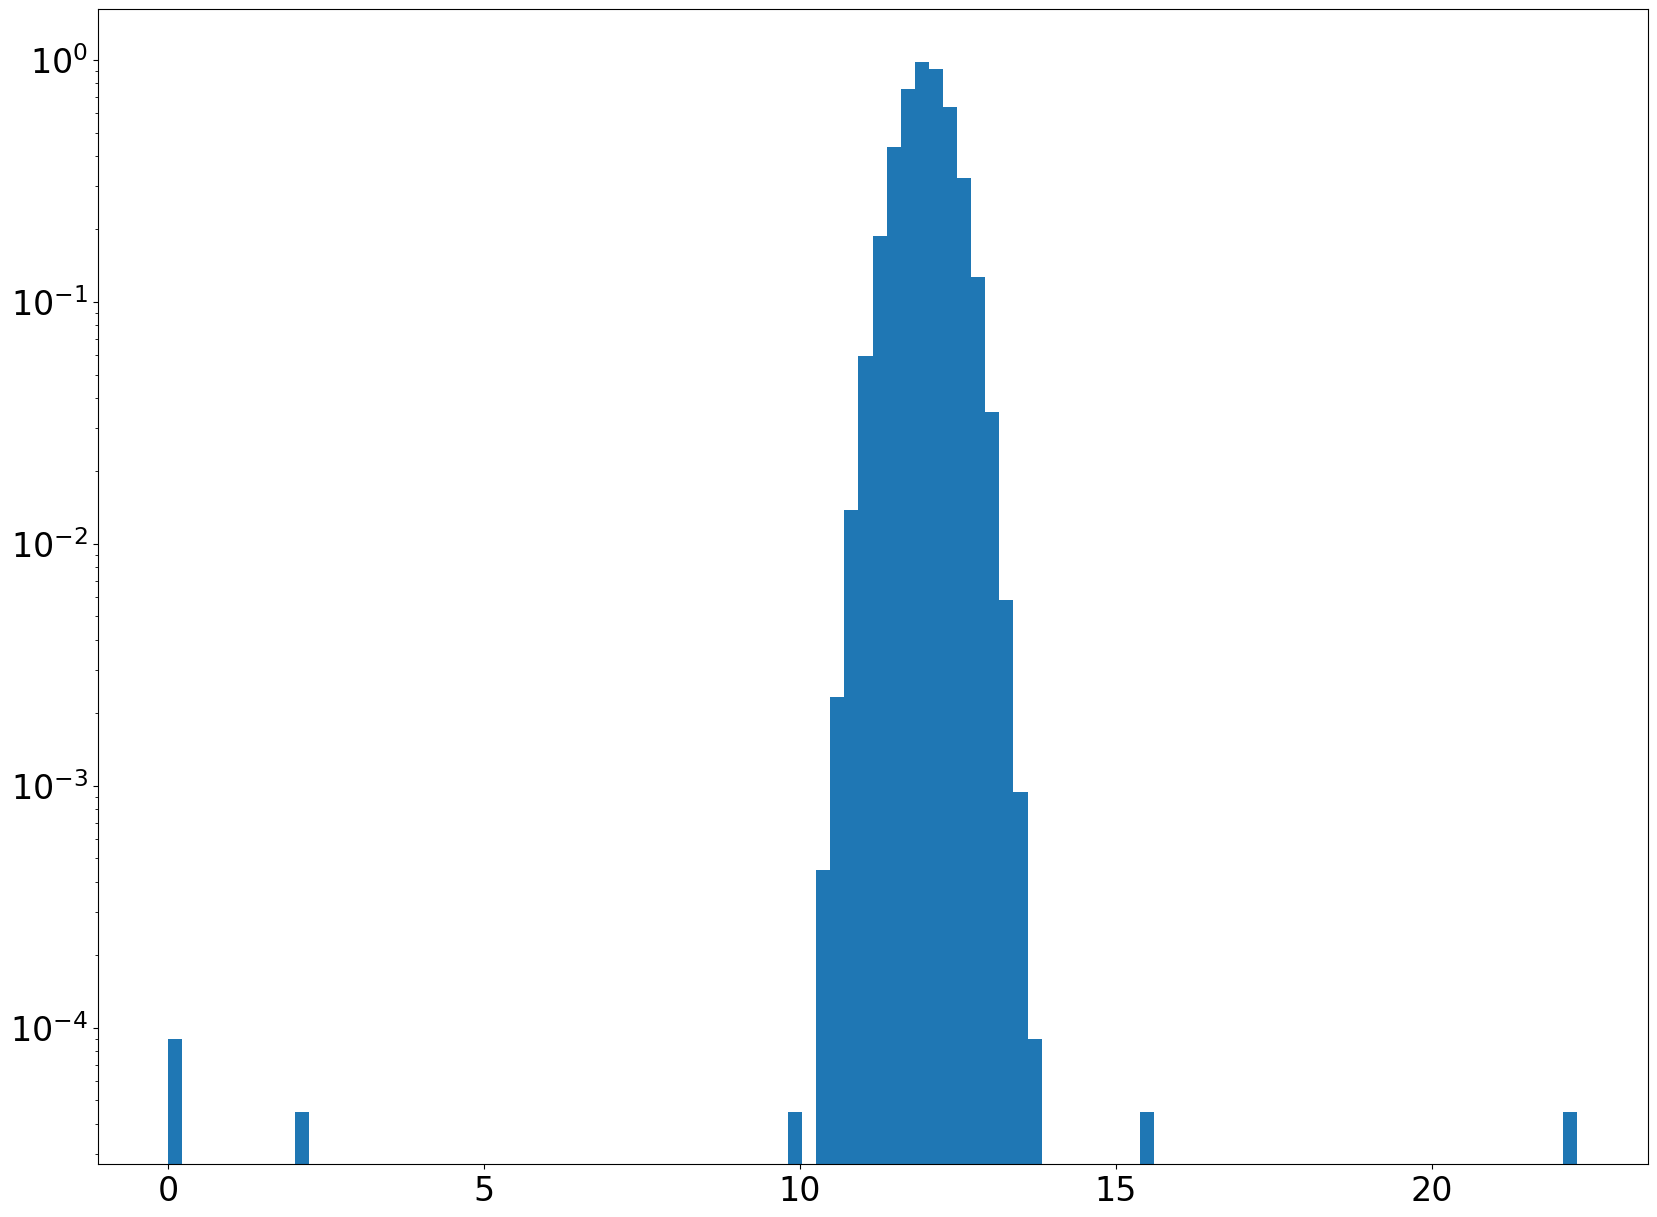

In [12]:
bad_values = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), bad_values)
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.show()

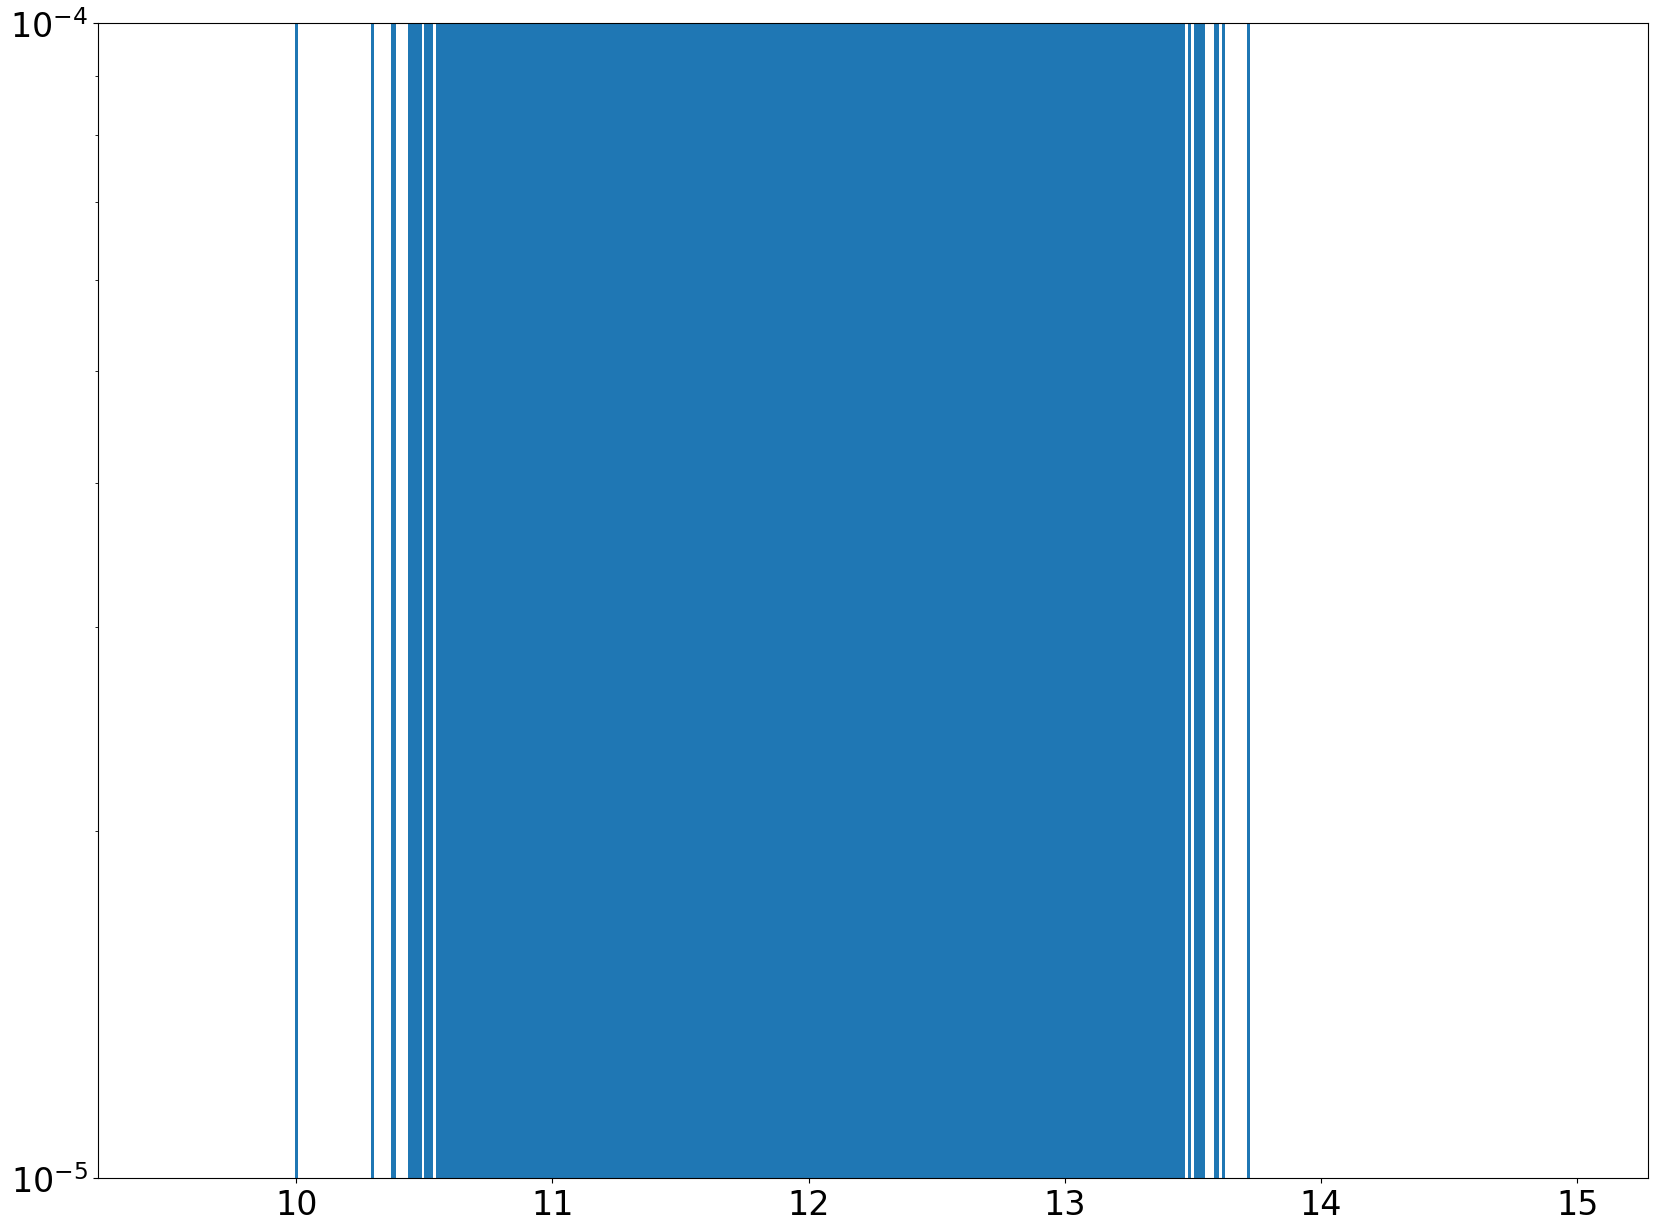

In [13]:
fig, ax = plt.subplots(1,1)
ax.hist(d, 500, range=(9.5,15), density=True)
plt.yscale('log')
plt.ylim([1e-5,1e-4])
plt.tick_params(labelsize=24)
plt.show()

3. I think the best threshold option would be to select a threshold that includes values up to and excluding the first outlier. For this distribution, these would be the values just before the associated probability of 10, on both sides. Now we just need to find out, what is the associated probability for a value of 10 so we can choose our cutoff point to be below this value?

In [14]:
ten_prob = stats.norm.cdf(10, loc=12, scale=0.4)
ten_sigma = stats.norm.ppf(ten_prob)
print(ten_sigma)

-5.000000000000001


Based on this, we will set our cutoff to 5 sigma, or 0.9999997. In effect, we will be removing values that, based on our background distribution, have a less than 1 in 3.3 million probability of occuring.

In [15]:
removed = d.copy()
removed.sort()
true_remove = 0
false_remove = 0
while stats.norm.ppf(stats.norm.cdf(removed[0], loc=12, scale=0.4)) <= -5:
    if removed[0] in bad_values:
        true_remove += 1
    else:
        false_remove += 1
    removed = np.delete(removed, 0)
while stats.norm.ppf(stats.norm.cdf(removed[len(removed)-1], loc=12, scale=0.4)) >= 5:
    if removed[len(removed)-1] in bad_values:
        true_remove += 1
    else:
        false_remove += 1
    removed = np.delete(removed, len(removed)-1)

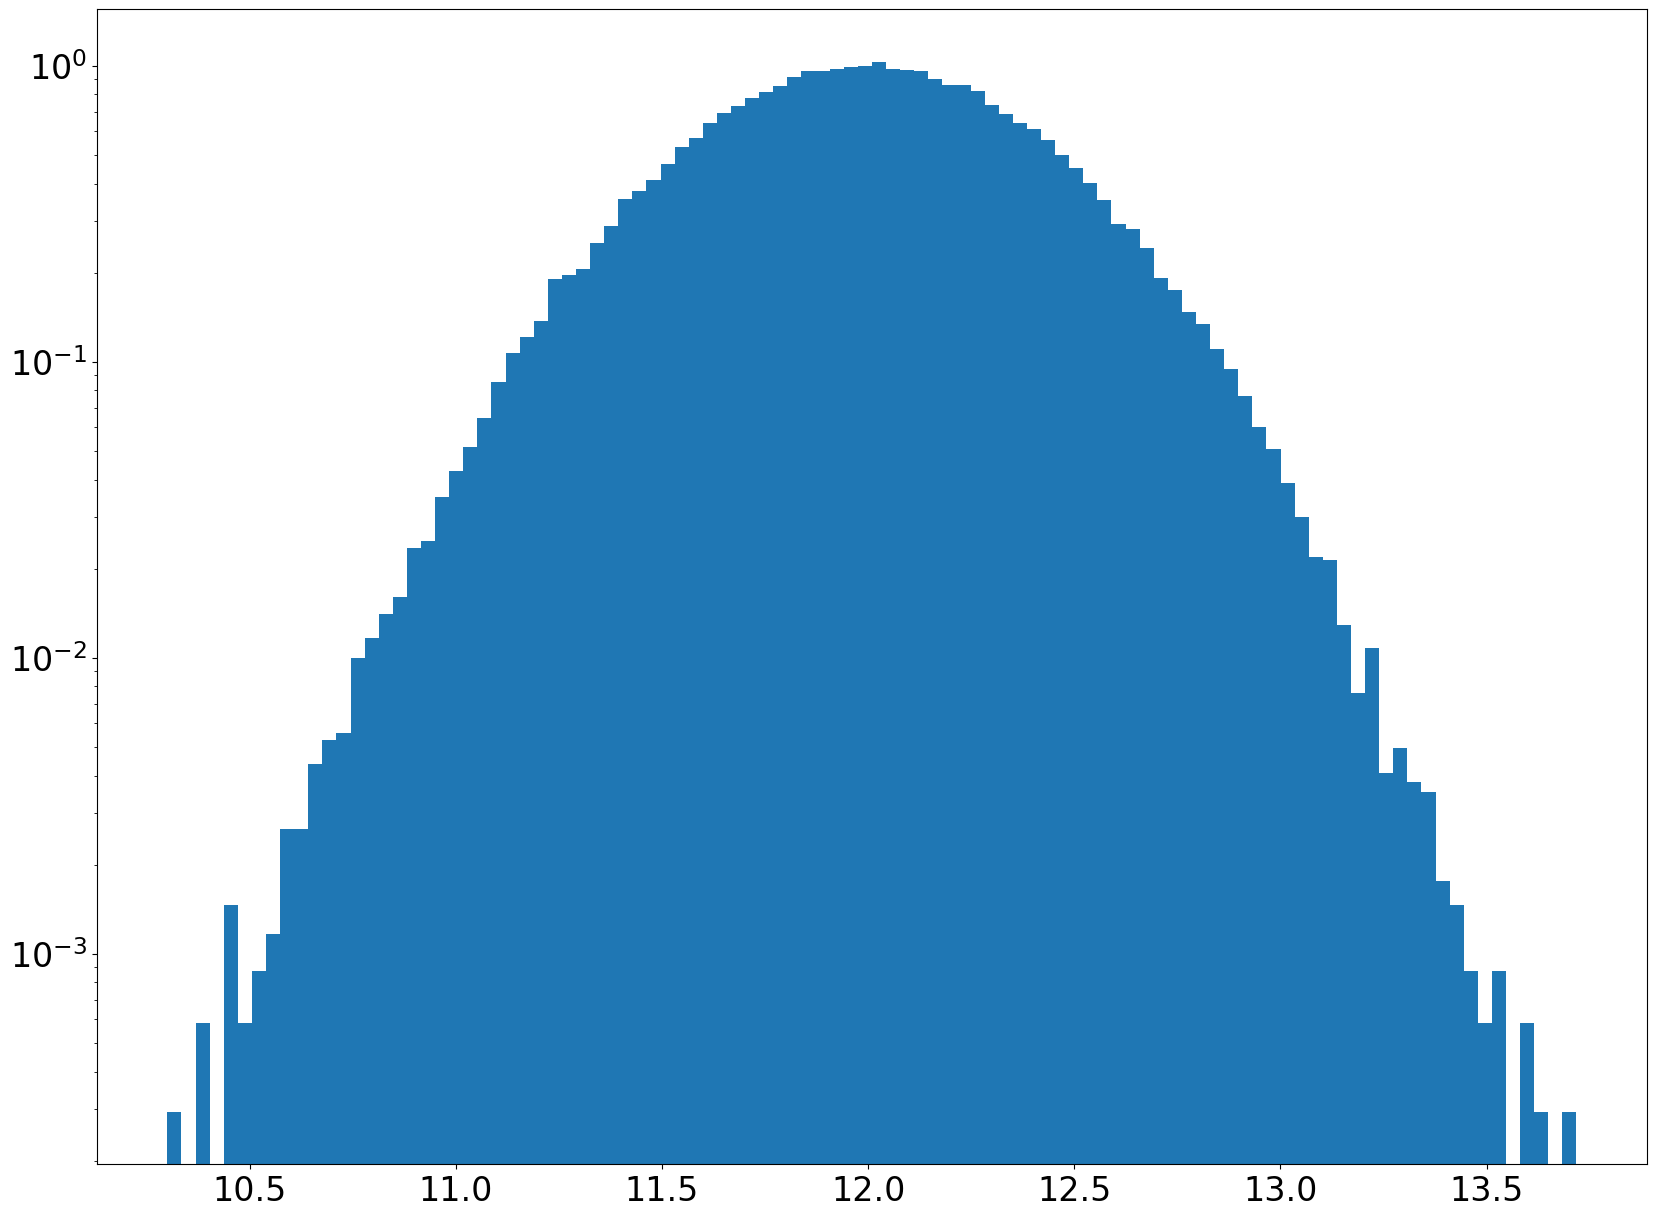

In [16]:
fig, ax = plt.subplots(1, 1)
ax.hist(removed,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.show()

In [17]:
print('               True T | Bad T')
print('-----------------------------')
print('  Test Good    {} | {}'.format((len(removed) - (len(bad_values)-true_remove)),(len(bad_values)-true_remove)))
print('   Test Bad       {}   | {}'.format(false_remove, true_remove))

               True T | Bad T
-----------------------------
  Test Good    100000 | 2
   Test Bad       0   | 6


B) With this statistical threshold, no good data was thrown out. This makes sense with the threshold chosen as the threshold throws out data with a less than 1 in 3.3 million chance of occuring. Since the original data consists of 100,000 data points, it's highly unlikely that the distribution would contain a point outside this threshold. 5 sigma also works well as a threshold as in this field of physics it's used as a marker of statistical significance.

C) There are two mistakes of commission here. The two points allowed are 10.3 and 12.7. Allowing 12.7 is fairly unavoidable as, since it's so close to the mean value, you would need to choose a threshold that would throw out tens of thousands of data points to remove this bad data, without knowing off the bat that this particular point is a misreading. However, 10.3 is much more avoidable. Unfortunately, the associated probability for 10.3 lies just inside a threshold of 1 in 100,000. This would be a very reasonable threshold to pick in this case as we have 100,000 points of data. So picking 1/100,000 would be a reasonable thing to do, however, in the situation that you don't know this 10.3 is a bad value, the only way to remove it would be to arbitrarily pick a lower threshold, in the hopes that you're playing things on the safe side and removing more bad values.

# Problem 2

1) Given a 2D Gaussian distribution describing the probable change in position of an object in space due to atmospheric and instrumental affects, with a detection treshold of 5 sigma of true movement (movement due to actually moving in space rather than discrepancies caused by the affects above), what is the distance in arcseconds of this 5 sigma movement of the resulting distribution of finding the magnitude with respect to the x and y directions?

To find the resulting distribution, we need to think about how to find the total distance traveled. This can simply be found by finding the magnitude constituted by the travel in both directions i.e. taking the square root of the sums of the squares of x and y. The square of a normal distribution is a chi-square distribution with 1 degree of freedom. Adding these two together results in a chi-square distribution with 2 degrees of freedom. Taking the square root of this at least yields a chi distribution with 2 degrees of freedom.

2) Finally, we only need to ask what is the associated value at 5 sigma of a chi distribution with 2 degrees of freedom?

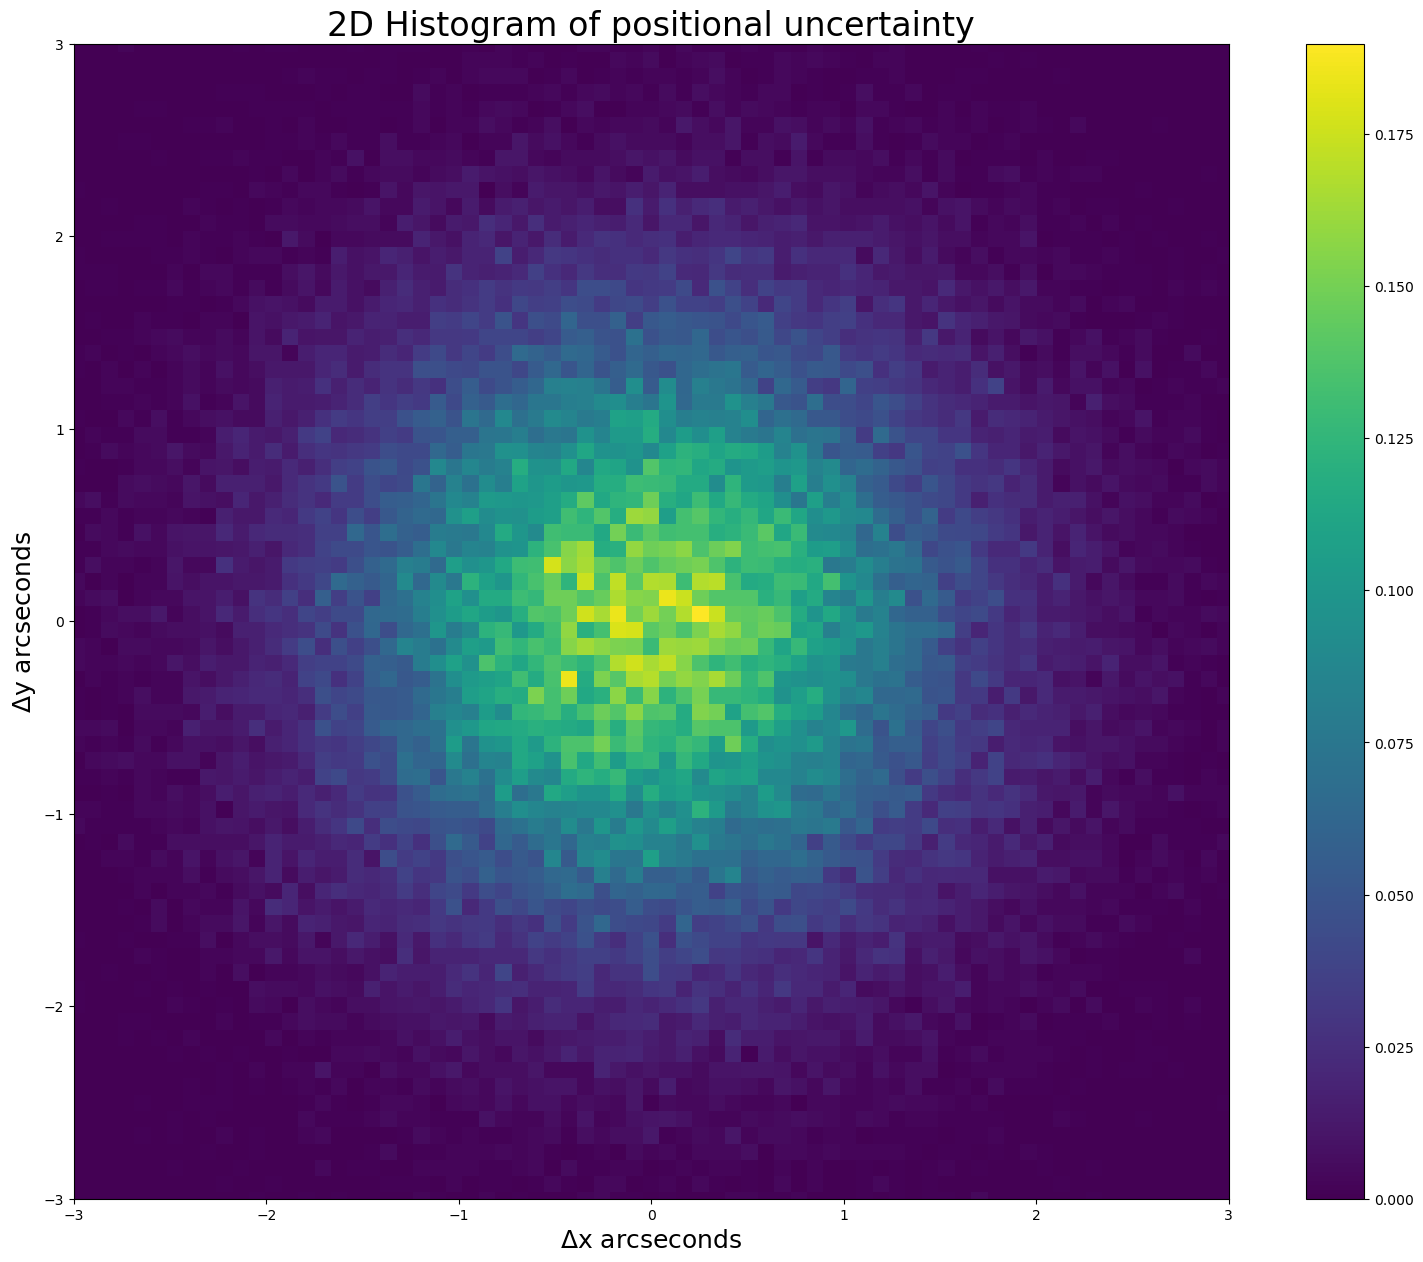

In [18]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

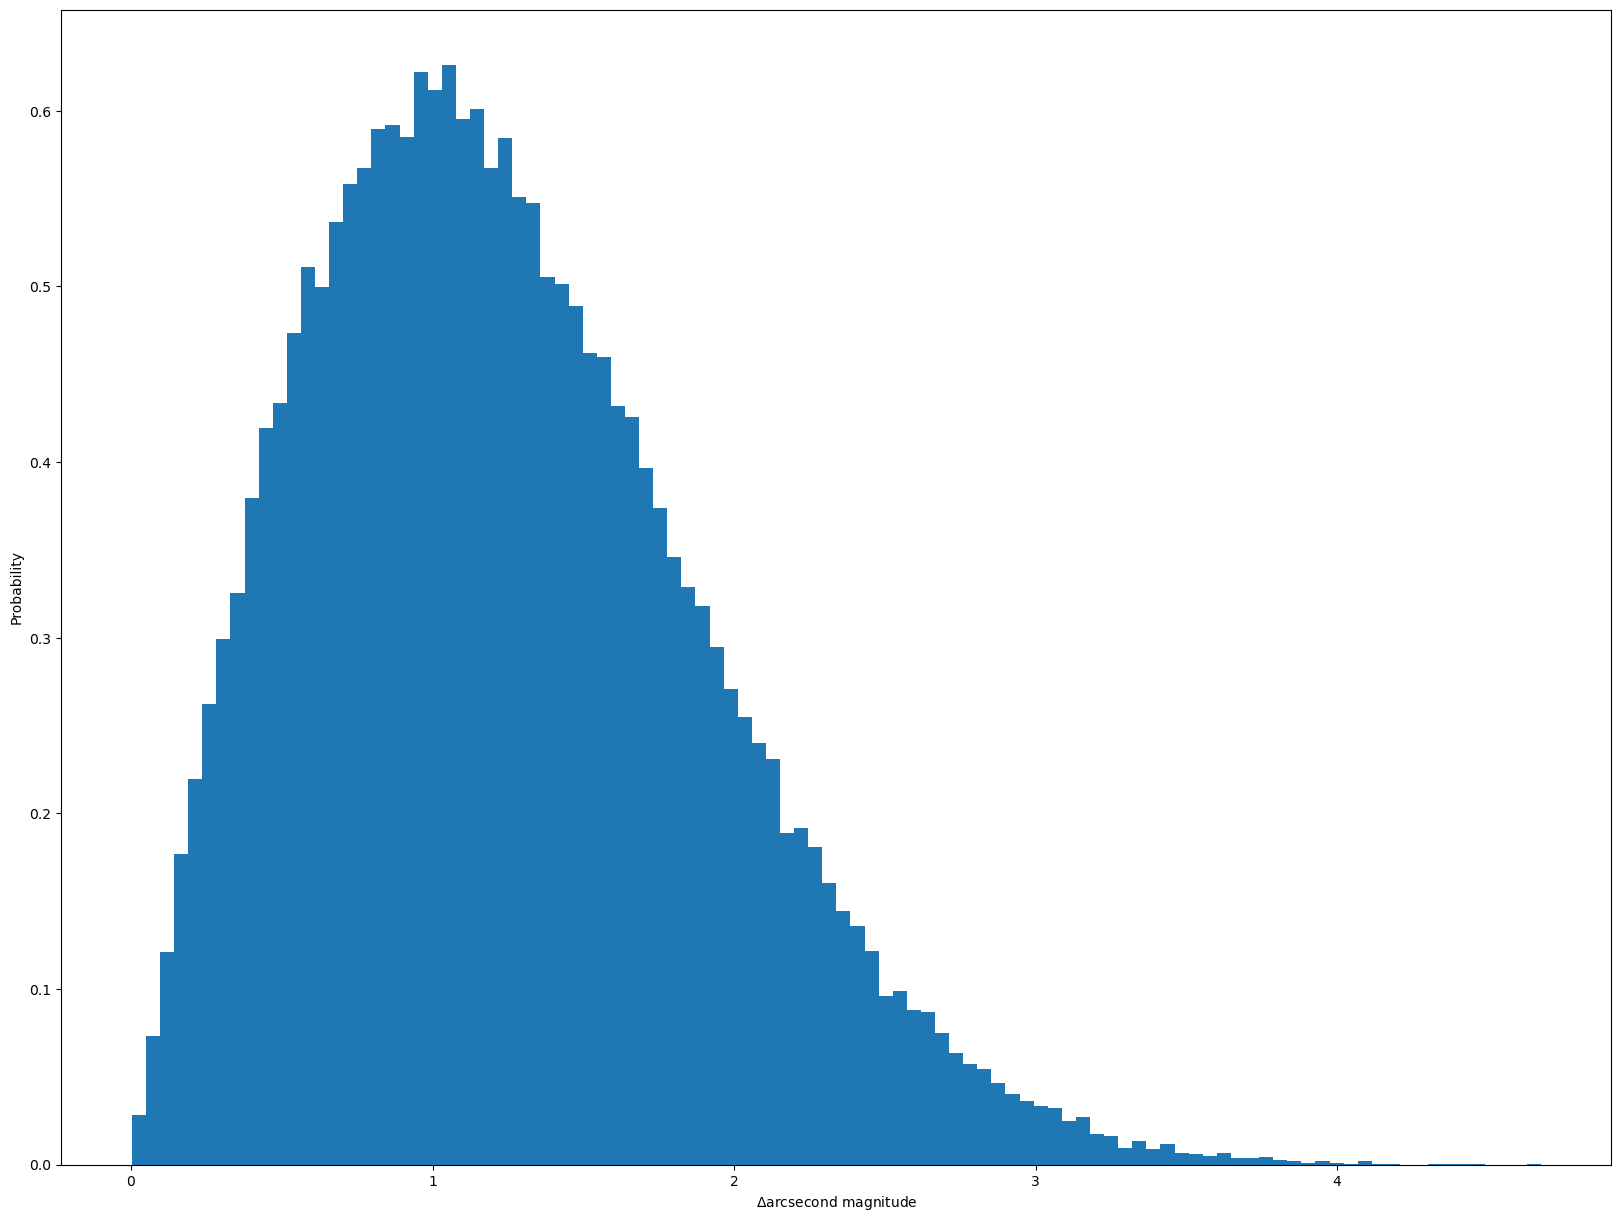

In [19]:
fig, ax = plt.subplots(1,1)
chi = stats.chi.rvs(2, size=100000)
ax.hist(chi,100,density=True)
ax.set_xlabel('$\Delta$arcsecond magnitude')
ax.set_ylabel('Probability')
plt.show()

In [20]:
prob_5_sigma = stats.norm.cdf(5)
chi_value = stats.chi.ppf(prob_5_sigma, 2)
print("The distance in arcseconds of a 5 sigma movement is: {:.3f}".format(chi_value))

The distance in arcseconds of a 5 sigma movement is: 5.489


# Problem 3

1. Over a period of 15 days, observing at night for 8 hours, what is our background distribution, and what is the significance of detecting 6800 cosmic rays during this time period?

2. Since we have an average rate of 1 cosmic ray per minute, and we have independent events occuring over a set period of time, our original background can be described by a poisson distribution of mean 1. Since we want to know the distribution over 7,200 minutes (60 * 8 * 15), we need only to sum 7,200 poissons together, which is the same as a poisson with mean 7200. Knowing this, we now need to integrate from negative infinity to 6800 over the pmf to find the significance.

3.

In [25]:
x = np.arange(stats.poisson.ppf(0.000001, 7200), stats.poisson.ppf(0.999999, 7200))

prob = stats.poisson.cdf(6800, 7200)
sigma = stats.norm.ppf(prob)
print(sigma)

-4.750747965777188


With a sigma value of 4.75, while close to 5, 6800 is still not a significant enough difference from the background distribution to warrant declaring any new discoveries.